# Aufgabe 3: Cross Validation und Grid Search

In dieser Aufgabe geht es um Hyperparameter-Optimierung mittels _Grid-Search_ (deutsch: Gittersuche). Dabei handelt es sich um eine Brute-Force-Suche, die auf einen angegebenen Teil des Hyperparameterraums angewandt wird. Sie wird dabei von einer Performance-Metrik geleitet.

Die Gittersuche soll in diesem Notebook auf zwei verschiedene Klassifikationsaufgaben angewandt werden, wobei die Anzahl der verwendeten CPU-Kerne variiert werden soll:

- Iris Flower Dataset
- Heart Disease UCI Dataset

Anschließend soll für beide Aufgaben jeweils eine Kurve mit der Suchzeit in Abhängigkeit vom Wert für den Parallelisierungsparameter `n_jobs` geplottet werden. Außerdem soll die Zielmetrik in Abhängigkeit von einem ausgewählten Hyperparameter geplottet werden.

_Bemerkung_: Für die Reproduktion der in diesem Notebook festgehaltenen Ergebnisse sollte es im SDIL Jupyter Hub ausgeführt werden, nachdem ein Server mit 8 Cores ausgewählt wurde!

In [Aufgabe 5](./Exercise5.ipynb) soll diese Aufgabe zudem im Batch-System des SDIL ausgeführt werden. Aus diesem Grund wird in diesem Notebook darauf geachtet, dass es ohne Probleme in ein auführbares Python-Skript konvertiert werden kann.

## Bibliotheken Importieren

Importieren der Bibliotheken. Beim Importieren von `matplotlib` muss darauf geachtet werden, das `agg`-Backend zu verwenden, wenn der Code nicht in einem Notebook ausgeführt wird, da es sonst zu Fehlern kommt.

In [1]:
## Import Libraries

# Technical
import time
import multiprocessing
import sys
from tqdm import tqdm

# Typical
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import datasets

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Matplotlib
if not 'ipykernel' in sys.modules:
    # Prevents errors when plotting outside Jupyter Notebook
    # For more information see exercise 5
    import matplotlib
    matplotlib.use('agg')
import matplotlib.pyplot as plt

## Funktions-Definitionen

Um bei der Gittersuche einfach die Anzahl der CPU-Kerne variieren zu können, wird zunächst eine Funktion definiert, welche die Gittersuche (`GridSearchCV`) in einer `for`-Schleife mit einer jeweils anderen Anzahl an CPU-Kernen ausführt.

In [2]:
def grid_search_with_cores(grid_search, X_train, y_train, core_range=None):
    """Fits given `sklearn.model_selection.GridSearchCV` on the training data. 
    This is done multiple times with different number of CPU cores.
    The numbers for CPU cores can be given with the core_range parameter.
    
    During computation, a progress bar is shown.
    
    Returns
    -------
    times : pandas.DataFrame
            Contains the time needed to train with the different numbers of CPU cores.
    """
    
    # If no core range is given, take all possible values
    if core_range is None:
        core_range = list(range(1, multiprocessing.cpu_count()+1))
        
    # Instanciate DataFrame for saving the training times
    times = pd.DataFrame(columns=['n_jobs', 'times'])

    # Show progress bar with tqdm
    for n in tqdm(core_range):
        # Instanciate Grid Search
        grid_search.n_jobs = n

        # Start time measurement
        start = time.time()

        # Modell trainieren
        grid_search.fit(X_train, y_train)

        # End time measurement
        end = time.time()

        # Append results
        times = times.append(pd.DataFrame.from_dict({'n_jobs': [n], 'times': [end - start]}))

    # Return times Dataframe and reference to the last GridSearchCV object
    return times

Als nächstes definieren wir eine Funktion zum Plotten der Kurve mit der Suchzeit in Abhängigkeit von der Anzahl an CPU- Kernen:

In [3]:
def plot_times(times):
    """Plots the times returned by grid_search_with_cores"""
    # Create the plot
    plot = times.plot(x='n_jobs', y='times', legend=False)
    # Set plot labels
    plot.set(xlabel="n_jobs", ylabel="Time in seconds")

Zum Schluss definieren wir noch eine Funktion zum Plotten der Zielmetrik in Abhängigkeit von einem (bzw. zwei) ausgewählten Hyperparametern.

In [4]:
def plot_grid_search(cv_results, grid, name_param_1, name_param_2, name_test_score='mean_test_score'):
    """ Plots the mean test score from the information of `GridSearchCV.cv_results_` for two given grid parameters.
    
    Adaption of: https://stackoverflow.com/a/43645640/6853900"""
    grid_param_1 = grid[name_param_1]
    grid_param_2 = grid[name_param_2]
    
    # Get Test Scores Mean for each grid search
    scores_mean = cv_results[name_test_score]
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    # Beautify the Plot (size, title, labels, legend, grid)
    ax.set_title("Grid Search Results", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel(name_test_score, fontsize=16)
    ax.legend(loc="best", fontsize=10)
    ax.grid('on')

## Iris Flower Dataset

###### Laden und Vorbereiten des Datensatzes

Siehe [Aufgabe 1](./Exercise1.ipynb) für mehr Details.

In [5]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
iris = pd.read_csv(url, names=names)

In [6]:
iris.shape

(150, 5)

In [7]:
# Split-out validation dataset like in the SDIL-Tutorial for comparability
array = iris.values
X = array[:,0:4]
Y = array[:,4]
test_size = 0.20
seed = 7
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

###### Ausführen der Gittersuche

Als Optimierungsparameter für die SVM aus dem Tutorial wurden die Parameter `C` (Penalty Parameter für den Fehlerterm, Standard: `1.0`) und `kernel` (Kerneltyp, Standard: `rbf`) gewählt.

Als Metrik für die Gittersuche wird standardmäßig die Methode `score` des Klassifikators verwendet, welche im Fall der `SVC`-Klasse die `accuracy` berechnet (siehe [GridSearchCV scoring](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), [SVC.score](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.score)).

Diese ist für die Klassifikationsaufgabe geeignet, da es sich um einen balancierten Datensatz handelt.

In [8]:
# Hyper-Parameter Space
grid_iris = {'C':list(np.logspace(-2, 10, num=13)), 'kernel':['linear','rbf']}

# SVM als Klassifikator
svc = svm.SVC(random_state=0)

# Instanciate GridSearchCV
grid_search_iris = GridSearchCV(svc, grid_iris)

# Execute grid search
times_iris = grid_search_with_cores(grid_search_iris, X_train, y_train, core_range=range(1,33))

100%|██████████| 32/32 [00:10<00:00,  2.54it/s]


###### Plot der Suchzeit in Abhängigkeit von `n_jobs`

In [9]:
print(times_iris)

  n_jobs     times
0      1  0.173085
0      2  0.293090
0      3  0.296390
0      4  0.305297
0      5  0.208213
0      6  0.212944
0      7  0.321680
0      8  0.226069
0      9  0.232626
0     10  0.239617
0     11  0.360094
0     12  0.252689
0     13  0.360880
0     14  0.273585
0     15  0.284461
0     16  0.289047
0     17  0.288631
0     18  0.298576
0     19  0.413990
0     20  0.312299
0     21  0.325769
0     22  0.332661
0     23  0.362951
0     24  0.347359
0     25  0.364171
0     26  0.349643
0     27  0.370320
0     28  0.395813
0     29  0.379124
0     30  0.377063
0     31  0.374777
0     32  0.428781


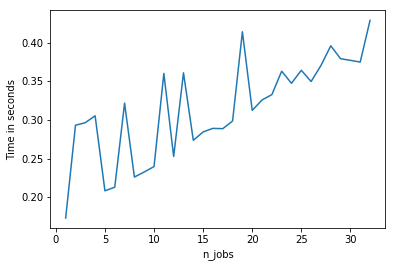

In [10]:
plot_times(times_iris)

Es ist zu erkennen, dass höhere Werte für `n_jobs` in diesem Fall nicht zu kürzeren Ausführungszeiten führen.  
Das könnte daran liegen, dass der Datensatz relativ klein ist und das Such-Grid nicht besonders groß.

###### Plot der Zielmetrik in Abhängigkeit vom Hyperparameter `C`

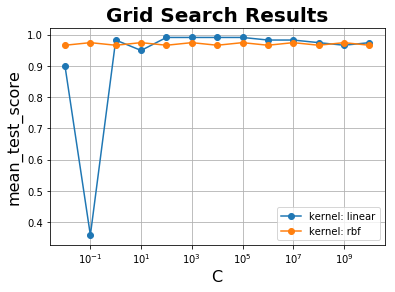

In [12]:
plot_grid_search(grid_search_iris.cv_results_, grid_iris, 'C', 'kernel')
plt.xscale("log")

Hinweis: Dieses Diagramm stellt die x-Achse logarithmisch dar.  
Beobachtung: Die Veränderung des Parameters `C` hat fast keine Auswirkung auf die Accuracy, wenn ein rbf-kernel verwendet wird. Wenn ein linearer kernel verwendet wird, wird die Accuracy für `C < 1` schlechter, vor allem für `C = 0.1`.

###### Validierung auf den Test-Daten

Zum Schluss soll die Performance des von der Gittersuche als besten identifizierten Klassifikators auf den Test-Daten ermittelt werden.

In [12]:
# Print the best estimator
grid_search_iris.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
# Predict with the best estimator and print the results
predictions = grid_search_iris.best_estimator_.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.9666666666666667
[[ 7  0  0]
 [ 0 11  1]
 [ 0  0 11]]


Dieses Ergebnis ist leicht besser als das Ergebnis des Klassifikators aus Aufgabe 1, welcher eine Accuracy von `0.93` auf den selben Testdaten hatte.

## Heart Disease UCI Dataset

Dieser Datensatz wurde auf [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci) gefunden.

Er enthält von 303 Patienten jeweils 14 Attribute und die Information darüber, ob sie eine Herzkrankheit haben oder nicht. 165 davon sind herzkrank, die restlichen 138 nicht.

Die ursprüngliche Quelle für den Datensatz ist das [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

Wir haben uns für den Datensatz entschieden, da er wenig Vorverarbeitung benötigt und annähernd balanciert ist.

###### Laden und Vorbereiten des Datensatzes

Die folgenden Zellen zum Laden und Vorverarbeiten der Daten sind zum Teil aus dem Kaggle-Notebook "[What Causes Heart Disease?](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model)" entnommen.

In [14]:
heart = pd.read_csv("./data/heart.csv")

In [15]:
heart.shape

(303, 14)

In [16]:
heart.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 
                 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved', 'exercise_induced_angina',
                 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [17]:
heart['sex'] = heart['sex'].astype('object')
heart['chest_pain_type'] = heart['chest_pain_type'].astype('object')
heart['fasting_blood_sugar'] = heart['fasting_blood_sugar'].astype('object')
heart['rest_ecg'] = heart['rest_ecg'].astype('object')
heart['exercise_induced_angina'] = heart['exercise_induced_angina'].astype('object')
heart['st_slope'] = heart['st_slope'].astype('object')
heart['thalassemia'] = heart['thalassemia'].astype('object')

In [18]:
heart = pd.get_dummies(heart, drop_first=True)

In [19]:
heart.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_1,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,fasting_blood_sugar_1,rest_ecg_1,rest_ecg_2,exercise_induced_angina_1,st_slope_1,st_slope_2,thalassemia_1,thalassemia_2,thalassemia_3
0,63,145,233,150,2.3,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
3,56,120,236,178,0.8,0,1,1,1,0,0,0,1,0,0,0,1,0,1,0
4,57,120,354,163,0.6,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0


In [20]:
#split the data
X_train, X_test, y_train, y_test = model_selection.train_test_split(heart.drop('target', 1), heart['target'], test_size = .2, random_state=10) 

###### Ausführen der Gittersuche

Für diese Klassifikationsaufgabe wurde ein Random-Forest-Klassifikator gewählt, da dieser auch im Kaggle-Notebook verwendet wird.

Als Optimierungsparameter wurden die Parameter `n_estimators` (Anzahl von Entscheidungsbäumen, Standard: `10`) und `max_features` (Anzahl der zu verwendenden Merkmale, Standard: `auto`) gewählt. Siehe auch die [Dokumentation zur Klasse `RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Als geeignete Zielmetriken habenen wir uns für die Maße Sensitivität (auch: Recall/TPR) und Spezifität (auch: TNR) entschieden, da sie typischerweise bei diagnostischen Testverfahren in der Medizin verwendet werden (siehe [Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)). Zudem sind unsere Ergebnisse dann leichter mit denen aus dem Kaggle-Notebook vergleichbar, da hier auch diese Metriken verwendet werden.

Weiterhin soll als Metrik die `accuracy` gemessen werden, da es sich um einen annähernd balancierten Datensatz handelt und in diese Metrik sowohl Sensitivität als auch Spezifität einfließen.

Die Berechnung der Zielmetriken wird hier definiert:

In [21]:
def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    return sensitivity

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

Ausführen der Gittersuche:

In [22]:
# SVM als Klassifikator
rfc = RandomForestClassifier(random_state=0)

# Hyper-Parameter Space
grid_heart = {'n_estimators': [int(x) for x in np.arange(start = 1, stop = 500, step = 10)],
              'max_depth': [None, 5, 10]}

# Define scoring
scoring = {'sensitivity': make_scorer(sensitivity_score), 
           'specificity': make_scorer(specificity_score),
           'accuracy': make_scorer(accuracy_score)}

# Instanciate GridSearchCV
grid_search_heart = GridSearchCV(rfc, grid_heart, scoring=scoring, refit='sensitivity')

# Execute grid search
times_heart = grid_search_with_cores(grid_search_heart, X_train=X_train, y_train=y_train, core_range=range(1,33))

100%|██████████| 32/32 [22:38<00:00, 30.88s/it]  


###### Plot der Suchzeit in Abhängigkeit von `n_jobs`

In [23]:
print(times_heart)

  n_jobs       times
0      1  221.322449
0      2  112.591162
0      3   75.727129
0      4   56.309758
0      5   45.351572
0      6   37.897383
0      7   33.128724
0      8   29.107206
0      9   28.778181
0     10   28.902741
0     11   29.668503
0     12   31.139054
0     13   33.977389
0     14   29.433154
0     15   31.368660
0     16   30.206588
0     17   32.328519
0     18   33.021458
0     19   30.996859
0     20   32.271576
0     21   31.121759
0     22   32.347874
0     23   31.986711
0     24   33.235514
0     25   30.501945
0     26   29.902407
0     27   30.883761
0     28   31.274429
0     29   30.779974
0     30   30.222670
0     31   32.026245
0     32   30.165507


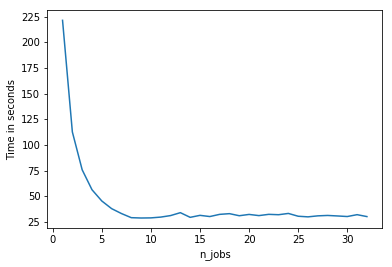

In [24]:
plot_times(times_heart)

In diesem Fall führen höhere Werte für `n_jobs` zu kürzeren Ausführungszeiten.

###### Plot der Zielmetriken in Abhängigkeit vom Hyperparameter `n_estimators`

Spezifität:

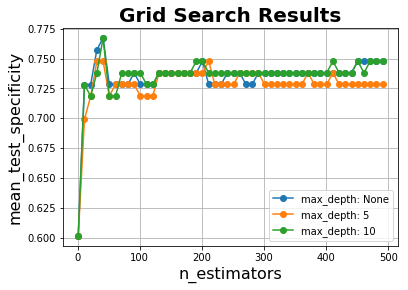

In [25]:
plot_grid_search(grid_search_heart.cv_results_, grid_heart, 'n_estimators', 'max_depth', 'mean_test_specificity')


Sensitivität:

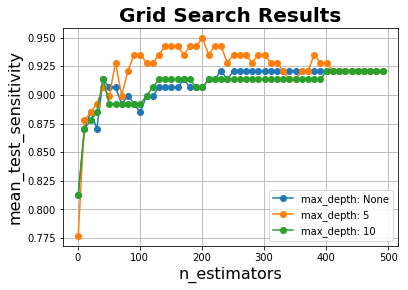

In [26]:
plot_grid_search(grid_search_heart.cv_results_, grid_heart, 'n_estimators', 'max_depth', 'mean_test_sensitivity')

Accuracy:

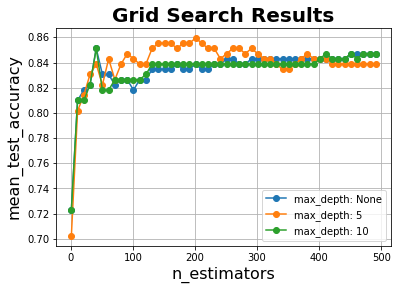

In [27]:
plot_grid_search(grid_search_heart.cv_results_, grid_heart, 'n_estimators', 'max_depth', 'mean_test_accuracy')

Beobachtung: Eine Erhöhung des Parameters `n_estimators` führt tendentiell zu besseren Klassifikationsergebnissen. Auf den Trainingsdaten ist ein Wert um 40 optimal.

###### Validierung auf den Test-Daten

Zum Schluss soll die Performance des von der Gittersuche als besten identifizierten Klassifikators auf den Test-Daten ermittelt werden.

In [28]:
# Print the best estimator
grid_search_heart.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=201, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [29]:
# Predict with the best estimator and print the results
predictions = grid_search_heart.best_estimator_.predict(X_test)
print("Sensitivity:", sensitivity_score(y_test, predictions))
print("Specificity:", specificity_score(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Sensitivity: 0.8076923076923077
Specificity: 0.8
Accuracy: 0.8032786885245902
[[28  7]
 [ 5 21]]


Für den Klassifikator im Kaggle-Notebook betragen die Werte Sensitivität `0.8846` bzw. Spezifität `0.8000` (Achtung: Im Kaggle-Notebook haben sich in der Berechnung hierfür Fehler eingeschlichen). Damit haben wir mithilfe der Grid-Search leider keinen Klassifikator gefunden, der auf den Test-Daten bessere Ergebnisse liefert.

Leider konnten die Ergebnisse aus dem Notebook auch nicht reproduziert werden, da dort kein `random_state` für den Random Forest gesetzt wurde.